In [1]:
import pandas as pd
import numpy as np 
import re
from gurobipy import *

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, mutual_info_score, normalized_mutual_info_score

from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col, when

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from CustomTransformers import *
from Evaluation import *
from ClassifierAnalyzer import *
from FeatureExtraction import *
from Filter import *

In [2]:
%load_ext autoreload
%autoreload 2

# Review Previous Work

In [3]:
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        return filter_data(self.data, terms, hashtags, users, locs, mentions)
    
    
class DataPreprocessor():
    def __init__(self, data, topic, load_labled=False, filter_empty_hashtags=False):
        if filter_empty_hashtags == True:
            self.data = data.filter(col("hashtag") != "empty_hashtag")
        else:
            self.data = data

        if load_labled == True:
            labled_dir = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/" + topic
            pos_dir = labled_dir + "/pos"
            topical_tweet_ids = spark.read.parquet(pos_dir)
            topical_tweets = topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(1))
            
            neg_dir = labled_dir + "/neg"
            non_topical_tweet_ids = spark.read.parquet(neg_dir).sample(False, 0.1, 123)
            non_topical_tweets = non_topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(0))

            self.labled_data = topical_tweets.union(non_topical_tweets)
        else:
            self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label"))
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_valid_time)
        validation_set = labled_data.where((col("create_time") > train_valid_time) \
                                           & (col("create_time") <= valid_test_time))
        test_set = labled_data.where(col("create_time") > valid_test_time)
        
        if remove_topic_hashtags == True:
            train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
            train_valid_hashtags = pd_ordered_hashtag_set[:valid_test_split_time]['each_hashtag'].tolist()
            
            train_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_hashtags]
            train_hashtags_regex = '|'.join(train_hashtags_filter)
            invalid_validation_ids = (validation_set.filter(validation_set['hashtag'].rlike(train_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            validation_set = validation_set.where(~col("tweet_id").isin(invalid_validation_ids))
            
            train_valid_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_valid_hashtags]
            train_valid_hashtags_regex = '|'.join(train_valid_hashtags_filter)
            invalid_test_ids = (test_set.filter(test_set['hashtag'].rlike(train_valid_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
                
            test_set = test_set.where(~col("tweet_id").isin(invalid_test_ids))
        
        if balance_data == True:
            train_pos_count = training_set.where(col("label") == 1).count()
            train_neg_count = training_set.count() - train_pos_count
            train_pos_neg_ratio = float(train_pos_count) / train_neg_count
            
            training_set = training_set.sampleBy("label", fractions={0.0: train_pos_neg_ratio, 1.0: 1}, seed=seed)
            
            valid_pos_count = validation_set.where(col("label") == 1).count()
            valid_neg_count = validation_set.count() - valid_pos_count
            valid_pos_neg_ratio = float(valid_pos_count) / valid_neg_count
            
            validation_set = validation_set.sampleBy("label", fractions={0.0: valid_pos_neg_ratio, 1.0: 1}, seed=seed)
            
        return training_set, validation_set, test_set

In [71]:
class TestFramework:
    def __init__(self, train, valid, test):
        self.train = train
        self.valid = valid
        self.test = test
                
        print("Initializing Classifier....")
        self.pipeline = self.initialize_pipeline()
        print("Complete!")
        self.analyzer = ClassifierAnalyzer(self.pipeline)
        
    def initialize_pipeline(self):        
        train_features = self.train.drop('label', axis=1)
        train_target = self.train['label']
        
        validation_features = self.valid.drop('label', axis=1)
        valid_target = self.valid['label']
        
        feature_transformer = FeatureUnion(
                                    transformer_list=[
                                        ('term', Pipeline([
                                            ('selector', ItemSelector(key='term')),
                                            ('count', CountVectorizer(stop_words='english', min_df=5)),
                                        ])),

                                        ('hashtag', Pipeline([
                                            ('selector', ItemSelector(key='hashtag')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('user', Pipeline([
                                            ('selector', ItemSelector(key='from_user')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('location', Pipeline([
                                            ('selector', ItemSelector(key='location')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('mention', Pipeline([
                                            ('selector', ItemSelector(key='mention')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ]))
                                    ])
            
        train_valid = pd.concat([train_features, validation_features])
        train_valid_target = pd.concat([train_target, valid_target])

        train_valid_transformed = feature_transformer.fit_transform(train_valid)
        
        train_transformed = feature_transformer.transform(train_features)
        valid_transformed = feature_transformer.transform(validation_features)
        
        # select c for best accuracy
        Cs = [100] #[0.01, 0.1, 1, 10, 100] TEMP
        best_classifier = None
        best_score = 0
        
        for c in Cs:
            classifier = LogisticRegression(C=c)
            classifier.fit(train_transformed, train_target)    
            c_score = classifier.score(valid_transformed, valid_target)
            if c_score > best_score:
                best_classifier = classifier
                best_score = c_score
               
        return Pipeline(steps=[('features', feature_transformer), ('classifier', best_classifier)])

    def get_pipeline(self):
        return self.pipeline
    
    def get_top_features(self, k):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.analyzer.get_top_features(k)
        
        print("Top Terms: ", top_terms)
        print("Top Hashtags: ", top_hashtags)
        print("Top Users: ", top_users)
        print("Top Locations: ", top_locs)
        print("Top Mentions: ", top_mentions)
    
    def get_top_features(self, k):
        return self.analyzer.get_top_features(k)
    
    def get_filtered_test_data(self, k, verbose=False):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.get_top_features(k)
        
        if verbose == True:
            print("Top Terms: ", top_terms)
            print("Top Hashtags: ", top_hashtags)
            print("Top Users: ", top_users)
            print("Top Locations: ", top_locs)
            print("Top Mentions: ", top_mentions)

        data = filter_data(self.test, top_terms, top_hashtags, top_users, top_locs, top_mentions)
        
        return data
    
    def get_filtered_data_by_index(self, indexes):
        features = get_feature_by_index(self.pipeline, indexes)
        
        terms = features[features.Type == "Term"].Feature.tolist()
        hashtags = features[features.Type == "Hashtag"].Feature.tolist()
        users = features[features.Type == "User"].Feature.tolist()
        locs = features[features.Type == "Location"].Feature.tolist()
        mentions = features[features.Type == "Mention"].Feature.tolist()
        
        data = filter_data(self.test, terms, hashtags, users, locs, mentions)
        
        return data
        
    def get_ideal_performance(self):
        test_features = self.test.drop('label', axis=1)
        test_target = self.test['label']

        predictions = self.pipeline.predict_proba(test_features)[:, 1]
        
        return model_evaluation_summary(test_target, predictions)
    
    def run_config_by_index(self, indexes):
        test = self.get_filtered_data_by_index(indexes)
        
        test_features = test.drop('label', axis=1)
        test_target = test['label']

        predictions = self.pipeline.predict_proba(test_features)[:, 1]
        
        return model_evaluation_summary(test_target, predictions)
    
    def run_with_filtered_test_data(self, test):        
        test_features = test.drop('label', axis=1)
        test_target = test['label']

        predictions = self.pipeline.predict_proba(test_features)[:, 1]
        
        return model_evaluation_summary(test_target, predictions)
     
    def run_configs(self, configs=[]):
        pipelines = []
        positive_counts = []
        total_counts = []
        aveps = []
        prec_recall = []
        
        for config in configs:
            test = self.get_filtered_test_data(config)
            positive_counts.append(len(test[test.label == 1]))     
            total_counts.append(len(test))
            
            test_features = test.drop('label', axis=1)
            test_target = test['label']
            
            predictions = self.pipeline.predict_proba(test_features)[:, 1]
            aveps.append(average_precision_score(test_target, predictions))

            precision, recall, _ = precision_recall_curve(test_target, predictions)
            prec_recall.append([precision, recall])
            
        return positive_counts, total_counts, pipelines, aveps, prec_recall

In [5]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

# Load Natural Disaster Splitted Data

In [6]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Natr_Disaster"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Test Classifier

In [72]:
tf = TestFramework(train_pd, validation_pd, test_pd)

Initializing Classifier....
Complete!


# Baseline

In [85]:
baseline_filtered_data = tf.get_filtered_test_data([50, 50, 50, 50, 50])

# GUROBI


In [9]:
test_pd_pd = test_pd.reset_index()

In [10]:
pipeline = tf.get_pipeline()

test_features = test_pd.drop('label', axis=1)
test_labels = test_pd['label']
transformed_test_data = pipeline.named_steps['features'].transform(test_features)

positive_indices = test_pd.index[test_pd.loc[:, 'label'] == 1]
positive_set = transformed_test_data[positive_indices]

negative_subset_index = test_pd[test_pd.label == 0].sample(frac=0.01, random_state=123).index
negative_set = transformed_test_data[negative_subset_index]

In [11]:
num_tweets = positive_set.shape[0]
num_features = positive_set.shape[1]

feature_positive_coverage = []
feature_negative_coverage = []
mutual_info_scores = []

for i in range(num_features):
    positive_coverage = positive_set[:, i].nonzero()[0]
    negative_coverage = negative_set[:, i].nonzero()[0]

    if len(positive_coverage) < 5:
        mi = 0
    else:
        mi = normalized_mutual_info_score(test_labels, transformed_test_data[:, i].toarray().flatten())

    feature_positive_coverage.append(positive_coverage)
    feature_negative_coverage.append(negative_coverage)
    mutual_info_scores.append(mi)

empty_location and empty_mention cannot be used in the actual API. even if they could be used, they will retrieve a lot of non-topical tweets which is not desirable. therefore remove them from the problem here. However, deleting the rows conataining these two values causes inconsistencies in the next steps, so set their coverage to zero so that they cannot be in the max cover solution.

In [12]:
empty_loc_index, empty_mention_index = get_empty_feature_indexes(pipeline)

feature_positive_coverage[empty_loc_index] = []
feature_negative_coverage[empty_loc_index] = []

feature_positive_coverage[empty_mention_index] = []
feature_negative_coverage[empty_mention_index] = []

## Max Cover Formulation

Now that we have the coverages for each feature, let's try solving max cover using gurobi:

![](maxcover_formulation.png)

In [14]:
def max_cover(feature_coverage, num_tweets, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(feature_coverage)

    m = Model()

    f = {} # Binary variable for each feature
    t = {} # Binary variables for each tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_tweets):
        t[j] = m.addVar(vtype=GRB.BINARY, name="t%d" % j)

    m.update()

    for j in range(num_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in feature_coverage[i]) >= t[j])

    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective(quicksum(t[j] for j in range(num_tweets)), GRB.MAXIMIZE)

    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

In [15]:
selected_features_index_basic = max_cover(feature_positive_coverage, num_tweets, 50)

Optimize a model with 3291 rows, 26006 columns and 53660 nonzeros
Variable types: 0 continuous, 26006 integer (26006 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 327 rows and 20465 columns
Presolve time: 0.09s
Presolved: 2964 rows, 5541 columns, 26458 nonzeros
Variable types: 0 continuous, 5541 integer (5541 binary)

Root relaxation: objective 3.158000e+03, 1088 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3158.0000000 3158.00000  0.00%     -    0s

Explored 0 nodes (1088 simplex iterations) in 0.17 seconds
Thread count was 32 (of 40 available processors)

Solution count 2: 3158 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective

In [16]:
get_feature_by_index(pipeline, selected_features_index_basic, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,amp,Term,245,607,0.000178
1,damage,Term,42,1,0.015402
2,day,Term,41,244,0.000138
3,earthquake,Term,44,0,0.028181
4,family,Term,36,54,0.000340
5,flood,Term,64,0,0.028574
6,good,Term,28,208,0.000172
7,help,Term,130,125,0.002327
8,hurricane,Term,156,1,0.092043
9,indian,Term,95,1,0.019877


From the previous report, the number of tweets returned was not the same as the returned filtered data. So the filtering function should be revised. filtering by "rt" should return 1947 positive rows.

SOLVED: The special case of empty lists was not handled in the filtering, causing most of the data to pass the filter.

In [17]:
filtered_data_basic = tf.get_filtered_data_by_index(selected_features_index_basic)

# Mutual Information

Now that we have calculated MI values for features, we can check how using features with top mi values can help us in optimizing the classifier:

In [18]:
mi_pd = pd.DataFrame(mutual_info_scores)
top_50_mi_scores_index = mi_pd.sort_values(0, ascending=False)[:50].index
get_feature_by_index(pipeline, top_50_mi_scores_index, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,earthquake,Hashtag,271,0,0.211200
1,hurricane,Hashtag,200,0,0.178641
2,storm,Hashtag,168,0,0.162134
3,typhoon,Hashtag,154,0,0.154494
4,sandy,Hashtag,116,0,0.132082
5,odile,Hashtag,108,0,0.126654
6,flood,Hashtag,106,0,0.125109
7,katrina,Hashtag,99,0,0.121032
8,bertha,Hashtag,99,0,0.119722
9,tornado,Hashtag,86,0,0.112011


In [19]:
filtered_data_by_mi = tf.get_filtered_data_by_index(top_50_mi_scores_index)

# Introduce Mutual Information to LP Formulation

As seen previously, the basic LP formulation does well on covering most of the topical tweets. However, in order to maximize the coverage, the model selects features that also bring in a lot of negative data (e.g. "rt") which is not desirable.
One idea is to somehow add mutual information in the formulation to control the precision in addition to recall. Below is a basic idea to do so which will be tested:

![](milp_1.png)

In [20]:
def max_cover_with_mutual_information(feature_coverage, mutual_info_scores, num_tweets, mi_weight=1000, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(feature_coverage)

    m = Model()
    m.setParam( 'OutputFlag', False )
    
    f = {} # Binary variable for each feature
    t = {} # Binary variables for each tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_tweets):
        t[j] = m.addVar(vtype=GRB.BINARY, name="t%d" % j)

    m.update()

    for j in range(num_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in feature_coverage[i]) >= t[j])

    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective(quicksum(t[j] for j in range(num_tweets)) \
                   + (mi_weight * quicksum(f[j]*mutual_info_scores[j] for j in range(num_features))), GRB.MAXIMIZE)

    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

Run multiple times with various weights for the second term to optimize a metric similar to f1 score 2 \*(prec \* recall) / (prec + recall):

In [21]:
weights = [1000, 5000, 10000, 20000]

total_positives = len(test_pd[test_pd.label == 1])
total_count = len(test_pd)

best_score = 0
best_weight = 0

for weight in weights:
    selected_features_index_milp = max_cover_with_mutual_information(feature_positive_coverage, mutual_info_scores, num_tweets\
                                                                     , mi_weight=weight, k=50)
    filtered_data_by_milp = tf.get_filtered_data_by_index(selected_features_index_milp)
    
    rec = (float)(len(filtered_data_by_milp[filtered_data_by_milp.label == 1])) / total_positives
    prec = (float)(len(filtered_data_by_milp[filtered_data_by_milp.label == 1])) / len(filtered_data_by_milp)
    score = (2 * prec * rec) / (prec + rec)
    print(score, rec, prec)
    if (score > best_score):
        best_score = score
        best_weight = weight

(0.010879135153859477, 0.9164133738601824, 0.005472048088685293)
(0.010814322841466936, 0.9106382978723404, 0.005439459685179469)
(0.010774546938244946, 0.9069908814589666, 0.005419463574811844)
(0.010774546938244946, 0.9069908814589666, 0.005419463574811844)


In [22]:
selected_features_index_milp = max_cover_with_mutual_information(feature_positive_coverage, mutual_info_scores\
                                                                     , num_tweets, mi_weight=best_weight, k=50)

In [24]:
get_feature_by_index(pipeline, selected_features_index_milp, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,03706060610,Term,13,0,0.040024
1,baja,Term,36,0,0.051667
2,earthquake,Term,44,0,0.028181
3,flood,Term,64,0,0.028574
4,floods,Term,70,2,0.055769
5,hurricane,Term,156,1,0.092043
6,kashmir,Term,108,2,0.070902
7,magnitude,Term,33,0,0.040865
8,philippines,Term,103,2,0.043021
9,quake,Term,35,0,0.038237


Check which features entered the solution in this problem:

In [29]:
entered_features = [f for f in selected_features_index_milp if f not in selected_features_index_basic]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Entered: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,03706060610,Term,13,0,0.040024
1,baja,Term,36,0,0.051667
2,floods,Term,70,2,0.055769
3,magnitude,Term,33,0,0.040865
4,philippines,Term,103,2,0.043021
5,relief,Term,91,6,0.038684
6,typhoon,Term,124,1,0.078988
7,sismo,Hashtag,46,0,0.061165
8,skywarn,Hashtag,20,0,0.050537
9,typhoonaid,Hashtag,13,0,0.040024


In [28]:
exitted_features = [f for f in selected_features_index_basic if f not in selected_features_index_milp]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Exitted: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,amp,Term,245,607,0.000178
1,damage,Term,42,1,0.015402
2,day,Term,41,244,0.000138
3,family,Term,36,54,0.000340
4,good,Term,28,208,0.000172
5,help,Term,130,125,0.002327
6,indian,Term,95,1,0.019877
7,just,Term,84,463,0.000143
8,life,Term,23,133,0.000072
9,live,Term,31,108,0.000001


In [30]:
filtered_data_by_milp = tf.get_filtered_data_by_index(selected_features_index_milp)

Introducing Mutual Information in this way improves the performance by replacing non-relevant features with more relevant ones to topics but still it can be seen that the huge coverage of terms like rt outweighs their low mutual information score. We can assign heavier weights to MI score to filter rt but that would cause a decrease in recalling the topical tweets.

# 2nd Formulation with Mutual Information

Instead of having a weight assigned to MI, we can normalize the recall metric to a range of [0, 1] by dividing the value by the total number of postive elements.

![](milp_2.png)

In [31]:
def max_cover_with_mutual_information_normalized(feature_coverage, mutual_info_scores, num_tweets, num_positives, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(feature_coverage)

    m = Model()
    #m.setParam('OutputFlag', False )
    
    f = {} # Binary variable for each feature
    t = {} # Binary variables for each tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_tweets):
        t[j] = m.addVar(vtype=GRB.BINARY, name="t%d" % j)

    m.update()

    for j in range(num_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in feature_coverage[i]) >= t[j])

    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective((quicksum(t[j] for j in range(num_tweets)) / (float)(num_positives)) \
                   +  quicksum(f[j]*mutual_info_scores[j] for j in range(num_features)), GRB.MAXIMIZE)

    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

In [32]:
num_positives = len(test_pd[test_pd.label == 1])
selected_features_index_milp_normalized = max_cover_with_mutual_information_normalized(feature_positive_coverage, \
                                                                            mutual_info_scores, num_tweets, \
                                                                            num_positives, k=50)

Optimize a model with 3291 rows, 26006 columns and 53660 nonzeros
Variable types: 0 continuous, 26006 integer (26006 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-09, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 0.2342955
Presolve removed 289 rows and 19770 columns
Presolve time: 0.09s
Presolved: 3002 rows, 6236 columns, 28746 nonzeros
Variable types: 0 continuous, 6236 integer (6230 binary)

Root relaxation: objective 4.570572e+00, 405 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.5705722    4.57057  0.00%     -    0s

Explored 0 nodes (405 simplex iterations) in 0.14 seconds
Thread count was 32 (of 40 available processors)

Solution count 2: 4.57057 0.234295 

Optimal solution found (tolerance 1.00e-04)
Best obj

In [66]:
get_feature_by_index(pipeline, selected_features_index_milp_normalized, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,03706060610,Term,13,0,0.040024
1,baja,Term,36,0,0.051667
2,floods,Term,70,2,0.055769
3,hurricane,Term,156,1,0.092043
4,kashmir,Term,108,2,0.070902
5,magnitude,Term,33,0,0.040865
6,philippines,Term,103,2,0.043021
7,quake,Term,35,0,0.038237
8,relief,Term,91,6,0.038684
9,rescue,Term,95,3,0.033248


In [33]:
entered_features = [f for f in selected_features_index_milp_normalized if f not in selected_features_index_milp]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Entered: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,sandyjobs,Hashtag,11,0,0.03657
1,sandy_jobs,User,11,0,0.03657


In [34]:
exitted_features = [f for f in selected_features_index_milp if f not in selected_features_index_milp_normalized]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Exitted: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,earthquake,Term,44,0,0.028181
1,flood,Term,64,0,0.028574


While most of the features selected are returned, the normlalized model has replaced earthquake and flood terms (their hashtags are still present in the solution set) with less relevant features.

In [62]:
filtered_data_by_milp_normalized = tf.get_filtered_data_by_index(selected_features_index_milp_normalized)

# Using Negative Coverages in LP Formulation

Another idea is to use the feature coverage of non-topical tweets in the maximization problem. We can use this information to penalize selecting too much of the negative data.

![](neg.png)

In [35]:
def max_cover_with_negs(positive_coverage, negative_coverage, num_positive_tweets, num_negative_tweets\
                        , penalty=0.1, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(positive_coverage)

    m = Model()
    m.setParam('OutputFlag', False )
    
    f = {} # Binary variable for each feature
    p = {} # Binary variables for each topical(positive) tweet
    n = {} # Binary variables for each non-topical(negative) tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_positive_tweets):
        p[j] = m.addVar(vtype=GRB.BINARY, name="p%d" % j)
        
    for j in range(num_negative_tweets):
        n[j] = m.addVar(vtype=GRB.BINARY, name="n%d" % j)
   
    m.update()

    for j in range(num_positive_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in positive_coverage[i]) >= p[j])

    for j in range(num_negative_tweets):
        m.addGenConstrOr(n[j], [f[i] for i in range(num_features) if j in negative_coverage[i]])        
        
    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective(quicksum(p[i] for i in range(num_positive_tweets)) \
                   - (penalty * (quicksum(n[i] for i in range(num_negative_tweets)))), GRB.MAXIMIZE)
    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

In [37]:
num_positives = positive_set.shape[0]
num_negatives = negative_set.shape[0]

total_positives = len(test_pd[test_pd.label == 1])
total_count = len(test_pd)

penalties = [0.1, 0.25, 0.5, 1]

best_score = 0
best_penalty = 0

for penalty in penalties:
    selected_features_index = max_cover_with_negs(feature_positive_coverage, feature_negative_coverage,\
                                                       num_positives, num_negatives\
                                                       , penalty=penalty, k=50)
    filtered_data = tf.get_filtered_data_by_index(selected_features_index)
    
    rec = (float)(len(filtered_data[filtered_data.label == 1])) / total_positives
    prec = (float)(len(filtered_data[filtered_data.label == 1])) / len(filtered_data)
    score = (2 * prec * rec) / (prec + rec)
    print(score, rec, prec)
    if (score > best_score):
        best_score = score
        best_penalty = penalty
        
#selected_features_neg_coverage = max_cover_f1_score(feature_positive_coverage, feature_negative_coverage,\
#                                                    num_positives, num_negatives, k=50)

(0.10425001887219748, 0.8395136778115502, 0.055575677089621314)
(0.1896233318234085, 0.8270516717325228, 0.10708803967098272)
(0.3141250878425861, 0.8151975683890578, 0.19454519077324822)
(0.3912914691943128, 0.8030395136778116, 0.2586645780301547)


In [38]:
selected_features_neg_coverage = max_cover_with_negs(feature_positive_coverage, feature_negative_coverage,\
                                                    num_positives, num_negatives, penalty=best_penalty, k=50)

In [41]:
get_feature_by_index(pipeline, selected_features_neg_coverage, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,affected,Term,36,2,0.012550
1,aftershocks,Term,14,0,0.032832
2,areas,Term,35,4,0.010303
3,damage,Term,42,1,0.015402
4,earthquake,Term,44,0,0.028181
5,flood,Term,64,0,0.028574
6,floods,Term,70,2,0.055769
7,hurricane,Term,156,1,0.092043
8,indian,Term,95,1,0.019877
9,kashmir,Term,108,2,0.070902


Comparing with the normalized MI model:

In [42]:
entered_features = [f for f in selected_features_neg_coverage if f not in selected_features_index_milp_normalized]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Entered: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,affected,Term,36,2,0.012550
1,aftershocks,Term,14,0,0.032832
2,areas,Term,35,4,0.010303
3,damage,Term,42,1,0.015402
4,earthquake,Term,44,0,0.028181
5,flood,Term,64,0,0.028574
6,indian,Term,95,1,0.019877
7,newport,Term,9,0,0.006522
8,rescued,Term,42,3,0.027702
9,stranded,Term,28,1,0.022701


In [43]:
exitted_features = [f for f in selected_features_index_milp_normalized if f not in selected_features_neg_coverage]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

Exitted: 


,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,03706060610,Term,13,0,0.040024
1,baja,Term,36,0,0.051667
2,magnitude,Term,33,0,0.040865
3,rt,Term,1947,5452,0.000858
4,typhoon,Term,124,1,0.078988
5,sandyjobs,Hashtag,11,0,0.036570
6,sismo,Hashtag,46,0,0.061165
7,skywarn,Hashtag,20,0,0.050537
8,typhoonaid,Hashtag,13,0,0.040024
9,warning,Hashtag,40,1,0.048300


In [63]:
filtered_data_by_neg_coverage = tf.get_filtered_data_by_index(selected_features_neg_coverage)

# Performance Results

### Training and Evaluating Classifiers

In [91]:
#_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
_, _, avep_baseline, prec_recall_baseline = tf.run_with_filtered_test_data(baseline_filtered_data)
#_, _, avep_mi, prec_recall_mi = tf.run_with_filtered_test_data(filtered_data_by_mi)
_, _, avep_basic, prec_recall_basic = tf.run_with_filtered_test_data(filtered_data_basic)
#_, _, avep_milp, prec_recall_milp = tf.run_with_filtered_test_data(filtered_data_by_milp)
#_, _, avep_milp_normalized, prec_recall_milp_normalized = tf.run_with_filtered_test_data(filtered_data_by_milp_normalized)
#_, _, avep_neg_coverage, prec_recall_neg_coverage = tf.run_with_filtered_test_data(filtered_data_by_neg_coverage)

In [93]:
# RECALL, PREC, Avep

results_pd = pd.DataFrame()

# Ideal
pos = len(test_pd[test_pd.label == 1])
tot = len(test_pd)
print("Number of Topical Tweets = {0}".format(pos))
print("Number of Tweets = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# Baseline
pos_ret = len(baseline_filtered_data[baseline_filtered_data.label == 1])
tot_ret = len(baseline_filtered_data)
recall = (float)(pos_ret) / pos

baseline_prec = prec_recall_baseline[0]
baseline_recall = recall * prec_recall_baseline[1]
results_pd = results_pd.append([["Baseline (Top Weighted Features in Classifier)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_baseline]])

# Top Mutual Information
pos_ret = len(filtered_data_by_mi[filtered_data_by_mi.label == 1])
tot_ret = len(filtered_data_by_mi)
recall = (float)(pos_ret) / pos

mi_prec = prec_recall_mi[0]
mi_recall = recall * prec_recall_mi[1]
results_pd = results_pd.append([["Top Mutual Information Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_mi]])

# Basic LP Max Coverage Formulation
pos_ret = len(filtered_data_basic[filtered_data_basic.label == 1])
tot_ret = len(filtered_data_basic)
recall = (float)(pos_ret) / pos

basic_prec = prec_recall_basic[0]
basic_recall = recall * prec_recall_basic[1]
results_pd = results_pd.append([["Basic Max Coverage LP Formulation", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_basic]])

# LP With Weighted MI Scores
pos_ret = len(filtered_data_by_milp[filtered_data_by_milp.label == 1])
tot_ret = len(filtered_data_by_milp)
recall = (float)(pos_ret) / pos

milp_prec = prec_recall_milp[0]
milp_recall = recall * prec_recall_milp[1]
results_pd = results_pd.append([["LP with Weighted MI Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_milp]])

# LP W/ Normalized Counts + MI
pos_ret = len(filtered_data_by_milp_normalized[filtered_data_by_milp_normalized.label == 1])
tot_ret = len(filtered_data_by_milp_normalized)
recall = (float)(pos_ret) / pos

milp_normalized_prec = prec_recall_milp_normalized[0]
milp_normalized_recall = recall * prec_recall_milp_normalized[1]
results_pd = results_pd.append([["LP with Normalized Coverage and MI Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_milp_normalized]])

# LP W/ Negative Coverage
pos_ret = len(filtered_data_by_neg_coverage[filtered_data_by_neg_coverage.label == 1])
tot_ret = len(filtered_data_by_neg_coverage)
recall = (float)(pos_ret) / pos

neg_coverage_prec = prec_recall_neg_coverage[0]
neg_coverage_recall = recall * prec_recall_neg_coverage[1]
results_pd = results_pd.append([["LP with Negative Covereage", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_neg_coverage]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "Classifier AveP"]
results_pd

#, , , ,
#total_positives = len(test_pd[test_pd.label == 1])
#total_count = len(test_pd)

Number of Topical Tweets = 3290
Number of Tweets = 1183224


,Model,Topical Retrieved,Total Retrieved,Recall,Precision,Classifier AveP
0,Ideal,3290,1183224,1.000000,0.002781,0.683623
0,Baseline (Top Weighted Features in Classifier),2301,28792,0.699392,0.079918,0.942199
0,Top Mutual Information Scores,2248,3409,0.683283,0.659431,0.974759
0,Basic Max Coverage LP Formulation,3158,671755,0.959878,0.004701,0.717030
0,LP with Weighted MI Scores,3015,550982,0.916413,0.005472,0.749856
0,LP with Normalized Coverage and MI Scores,2996,550790,0.910638,0.005439,0.751519
0,LP with Negative Covereage,2642,10214,0.803040,0.258665,0.890862


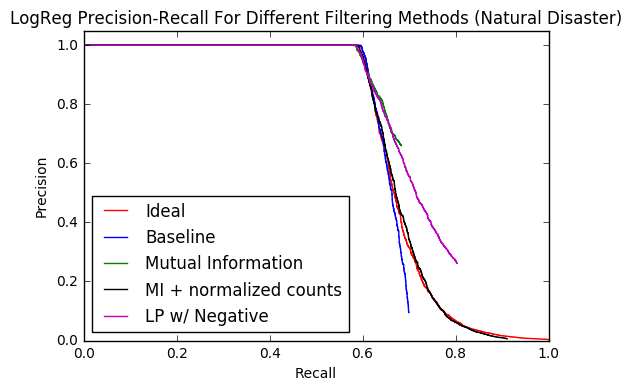

In [112]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(baseline_recall, baseline_prec, color=colors[1], label="Baseline")
plt.plot(mi_recall, mi_prec, color=colors[2], label="Mutual Information")
plt.plot(milp_normalized_recall, milp_normalized_prec, color=colors[3], label="MI + normalized counts")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")
#plt.step(weighted_maxcover_recall_scaled, maxcover_prec_recall[0], color=colors[2], label="MaxCover")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()

# Test On another topic (Soccer)

In [118]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Social_issue"

dp = DataPreprocessor(raw_data, topic)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [119]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

In [121]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [125]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

In [126]:
dp = DataPreprocessor(raw_data, topic, load_labled=True, filter_empty_hashtags=True)

In [127]:
train, valid, test = dp.temporal_split(topic, remove_topic_hashtags=True)

In [130]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Social_issue"

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [131]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [132]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

## (LOAD CSV)

In [138]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Social_issue"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [139]:
tf = TestFramework(train_pd, validation_pd, test_pd)

Initializing Classifier....
Complete!


In [140]:
baseline_filtered_data = tf.get_filtered_test_data([50, 50, 50, 50, 50])

In [147]:
test_pd = test_pd.reset_index()

In [153]:
pipeline = tf.get_pipeline()

test_features = test_pd.drop('label', axis=1)
test_labels = test_pd['label']
transformed_test_data = pipeline.named_steps['features'].transform(test_features)

positive_indices = test_pd[test_pd.label == 1].index
positive_set = transformed_test_data[positive_indices.values]

negative_subset_index = test_pd[test_pd.label == 0].sample(frac=0.01, random_state=123).index
negative_set = transformed_test_data[negative_subset_index]

In [155]:
num_tweets = positive_set.shape[0]
num_features = positive_set.shape[1]

feature_positive_coverage = []
feature_negative_coverage = []
mutual_info_scores = []

for i in range(num_features):
    positive_coverage = positive_set[:, i].nonzero()[0]
    negative_coverage = negative_set[:, i].nonzero()[0]

    if len(positive_coverage) < 5:
        mi = 0
    else:
        mi = normalized_mutual_info_score(test_labels, transformed_test_data[:, i].toarray().flatten())

    feature_positive_coverage.append(positive_coverage)
    feature_negative_coverage.append(negative_coverage)
    mutual_info_scores.append(mi)

In [156]:
empty_loc_index, empty_mention_index = get_empty_feature_indexes(pipeline)

feature_positive_coverage[empty_loc_index] = []
feature_negative_coverage[empty_loc_index] = []

feature_positive_coverage[empty_mention_index] = []
feature_negative_coverage[empty_mention_index] = []

In [163]:
selected_features_index_basic = max_cover(feature_positive_coverage, num_tweets, 50)

Optimize a model with 48725 rows, 101408 columns and 582229 nonzeros
Variable types: 0 continuous, 101408 integer (101408 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 7609 rows and 45485 columns
Presolve time: 1.77s
Presolved: 41116 rows, 55923 columns, 452029 nonzeros
Variable types: 0 continuous, 55923 integer (55923 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Presolved: 41116 rows, 55923 columns, 452029 nonzeros

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.825780e+04, 3693 iterations, 2.81 seconds
Total elapsed time = 5.09s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 48257.8000    0  125

In [164]:
get_feature_by_index(pipeline, selected_features_index_basic, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,12,Term,429,12,0.002699
1,america,Term,1114,1,0.039027
2,amp,Term,2786,153,0.000101
3,black,Term,2850,14,0.049085
4,christmas,Term,177,38,0.005347
5,cop,Term,1332,1,0.054984
6,cops,Term,1472,1,0.059872
7,criminal,Term,147,1,0.006225
8,dont,Term,1795,47,0.002655
9,family,Term,825,12,0.006042


In [165]:
filtered_data_basic = tf.get_filtered_data_by_index(selected_features_index_basic)

In [166]:
mi_pd = pd.DataFrame(mutual_info_scores)
top_50_mi_scores_index = mi_pd.sort_values(0, ascending=False)[:50].index
get_feature_by_index(pipeline, top_50_mi_scores_index, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

,Feature,Type,Positive Coverage,Negative Coverage,MI Score
0,ferguson,Hashtag,24530,0,0.485148
1,ericgarner,Hashtag,7094,0,0.202505
2,blacklivesmatter,Hashtag,5412,0,0.170955
3,icantbreathe,Hashtag,5150,0,0.165483
4,police,Term,5101,6,0.117814
5,mikebrown,Hashtag,2271,0,0.100728
6,protesters,Term,2346,1,0.089479
7,deray,Mention,1677,1,0.079833
8,protest,Term,2005,0,0.071611
9,michaelbrown,Hashtag,1155,0,0.067793


In [ ]:
filtered_data_by_mi = tf.get_filtered_data_by_index(top_50_mi_scores_index)

In [ ]:
weights = [1000, 5000, 10000, 20000]

total_positives = len(test_pd[test_pd.label == 1])
total_count = len(test_pd)

best_score = 0
best_weight = 0

for weight in weights:
    selected_features_index_milp = max_cover_with_mutual_information(feature_positive_coverage, mutual_info_scores, num_tweets\
                                                                     , mi_weight=weight, k=50)
    filtered_data_by_milp = tf.get_filtered_data_by_index(selected_features_index_milp)
    
    rec = (float)(len(filtered_data_by_milp[filtered_data_by_milp.label == 1])) / total_positives
    prec = (float)(len(filtered_data_by_milp[filtered_data_by_milp.label == 1])) / len(filtered_data_by_milp)
    score = (2 * prec * rec) / (prec + rec)
    print(score, rec, prec)
    if (score > best_score):
        best_score = score
        best_weight = weight

(0.29304436305665177, 0.9959773417617601, 0.17179573413576424)


In [ ]:
selected_features_index_milp = max_cover_with_mutual_information(feature_positive_coverage, mutual_info_scores\
                                                                     , num_tweets, mi_weight=best_weight, k=50)

In [ ]:
get_feature_by_index(pipeline, selected_features_index_milp, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
entered_features = [f for f in selected_features_index_milp if f not in selected_features_index_basic]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
exitted_features = [f for f in selected_features_index_basic if f not in selected_features_index_milp]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
filtered_data_by_milp = tf.get_filtered_data_by_index(selected_features_index_milp)

In [ ]:
def max_cover_with_mutual_information_normalized(feature_coverage, mutual_info_scores, num_tweets, num_positives, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(feature_coverage)

    m = Model()
    #m.setParam('OutputFlag', False )
    
    f = {} # Binary variable for each feature
    t = {} # Binary variables for each tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_tweets):
        t[j] = m.addVar(vtype=GRB.BINARY, name="t%d" % j)

    m.update()

    for j in range(num_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in feature_coverage[i]) >= t[j])

    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective((quicksum(t[j] for j in range(num_tweets)) / (float)(num_positives)) \
                   +  quicksum(f[j]*mutual_info_scores[j] for j in range(num_features)), GRB.MAXIMIZE)

    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

In [ ]:
num_positives = len(test_pd[test_pd.label == 1])
selected_features_index_milp_normalized = max_cover_with_mutual_information_normalized(feature_positive_coverage, \
                                                                            mutual_info_scores, num_tweets, \
                                                                            num_positives, k=50)

In [ ]:
get_feature_by_index(pipeline, selected_features_index_milp_normalized, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
entered_features = [f for f in selected_features_index_milp_normalized if f not in selected_features_index_milp]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
exitted_features = [f for f in selected_features_index_milp if f not in selected_features_index_milp_normalized]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
filtered_data_by_milp_normalized = tf.get_filtered_data_by_index(selected_features_index_milp_normalized)

In [ ]:
def max_cover_with_negs(positive_coverage, negative_coverage, num_positive_tweets, num_negative_tweets\
                        , penalty=0.1, k=20):
    # feature_coverage: tweets covered by each feature
    num_features = len(positive_coverage)

    m = Model()
    m.setParam('OutputFlag', False )
    
    f = {} # Binary variable for each feature
    p = {} # Binary variables for each topical(positive) tweet
    n = {} # Binary variables for each non-topical(negative) tweet
    
    for i in range(num_features):
        f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

    for j in range(num_positive_tweets):
        p[j] = m.addVar(vtype=GRB.BINARY, name="p%d" % j)
        
    for j in range(num_negative_tweets):
        n[j] = m.addVar(vtype=GRB.BINARY, name="n%d" % j)
   
    m.update()

    for j in range(num_positive_tweets):
        m.addConstr(quicksum(f[i] for i in range(num_features) if j in positive_coverage[i]) >= p[j])

    for j in range(num_negative_tweets):
        m.addGenConstrOr(n[j], [f[i] for i in range(num_features) if j in negative_coverage[i]])        
        
    m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

    m.setObjective(quicksum(p[i] for i in range(num_positive_tweets)) \
                   - (penalty * (quicksum(n[i] for i in range(num_negative_tweets)))), GRB.MAXIMIZE)
    m.optimize()
    
    model_vars = m.getVars()[:num_features]
    selected_features_index = []

    for i in range(len(model_vars)):
        if model_vars[i].X > 0:
            selected_features_index.append(i)
            
    return selected_features_index

In [ ]:
num_positives = positive_set.shape[0]
num_negatives = negative_set.shape[0]

total_positives = len(test_pd[test_pd.label == 1])
total_count = len(test_pd)

penalties = [0.1, 0.25, 0.5, 1]

best_score = 0
best_penalty = 0

for penalty in penalties:
    selected_features_index = max_cover_with_negs(feature_positive_coverage, feature_negative_coverage,\
                                                       num_positives, num_negatives\
                                                       , penalty=penalty, k=50)
    filtered_data = tf.get_filtered_data_by_index(selected_features_index)
    
    rec = (float)(len(filtered_data[filtered_data.label == 1])) / total_positives
    prec = (float)(len(filtered_data[filtered_data.label == 1])) / len(filtered_data)
    score = (2 * prec * rec) / (prec + rec)
    print(score, rec, prec)
    if (score > best_score):
        best_score = score
        best_penalty = penalty
        
#selected_features_neg_coverage = max_cover_f1_score(feature_positive_coverage, feature_negative_coverage,\
#                                                    num_positives, num_negatives, k=50)

In [ ]:
selected_features_neg_coverage = max_cover_with_negs(feature_positive_coverage, feature_negative_coverage,\
                                                    num_positives, num_negatives, penalty=best_penalty, k=50)

In [ ]:
get_feature_by_index(pipeline, selected_features_neg_coverage, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
entered_features = [f for f in selected_features_neg_coverage if f not in selected_features_index_milp_normalized]
print("Entered: ")
get_feature_by_index(pipeline, entered_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
exitted_features = [f for f in selected_features_index_milp_normalized if f not in selected_features_neg_coverage]
print("Exitted: ")
get_feature_by_index(pipeline, exitted_features, pos_coverages=feature_positive_coverage, \
                     neg_coverages=feature_negative_coverage, mutual_info_scores=mutual_info_scores)

In [ ]:
filtered_data_by_neg_coverage = tf.get_filtered_data_by_index(selected_features_neg_coverage)

# Performance

In [ ]:
_, _, ideal_avep, ideal_prec_recall = tf.get_ideal_performance()
_, _, avep_baseline, prec_recall_baseline = tf.run_with_filtered_test_data(baseline_filtered_data)
_, _, avep_mi, prec_recall_mi = tf.run_with_filtered_test_data(filtered_data_by_mi)
_, _, avep_basic, prec_recall_basic = tf.run_with_filtered_test_data(filtered_data_basic)
_, _, avep_milp, prec_recall_milp = tf.run_with_filtered_test_data(filtered_data_by_milp)
_, _, avep_milp_normalized, prec_recall_milp_normalized = tf.run_with_filtered_test_data(filtered_data_by_milp_normalized)
_, _, avep_neg_coverage, prec_recall_neg_coverage = tf.run_with_filtered_test_data(filtered_data_by_neg_coverage)

In [ ]:
# RECALL, PREC, Avep

results_pd = pd.DataFrame()

# Ideal
pos = len(test_pd[test_pd.label == 1])
tot = len(test_pd)
print("Number of Topical Tweets = {0}".format(pos))
print("Number of Tweets = {0}".format(tot))

results_pd = results_pd.append([["Ideal", pos, tot, 1.0, (float)(pos) / tot, ideal_avep]])

# Baseline
pos_ret = len(baseline_filtered_data[baseline_filtered_data.label == 1])
tot_ret = len(baseline_filtered_data)
recall = (float)(pos_ret) / pos

baseline_prec = prec_recall_baseline[0]
baseline_recall = recall * prec_recall_baseline[1]
results_pd = results_pd.append([["Baseline (Top Weighted Features in Classifier)", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_baseline]])

# Top Mutual Information
pos_ret = len(filtered_data_by_mi[filtered_data_by_mi.label == 1])
tot_ret = len(filtered_data_by_mi)
recall = (float)(pos_ret) / pos

mi_prec = prec_recall_mi[0]
mi_recall = recall * prec_recall_mi[1]
results_pd = results_pd.append([["Top Mutual Information Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_mi]])

# Basic LP Max Coverage Formulation
pos_ret = len(filtered_data_basic[filtered_data_basic.label == 1])
tot_ret = len(filtered_data_basic)
recall = (float)(pos_ret) / pos

basic_prec = prec_recall_basic[0]
basic_recall = recall * prec_recall_basic[1]
results_pd = results_pd.append([["Basic Max Coverage LP Formulation", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_basic]])

# LP With Weighted MI Scores
pos_ret = len(filtered_data_by_milp[filtered_data_by_milp.label == 1])
tot_ret = len(filtered_data_by_milp)
recall = (float)(pos_ret) / pos

milp_prec = prec_recall_milp[0]
milp_recall = recall * prec_recall_milp[1]
results_pd = results_pd.append([["LP with Weighted MI Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_milp]])

# LP W/ Normalized Counts + MI
pos_ret = len(filtered_data_by_milp_normalized[filtered_data_by_milp_normalized.label == 1])
tot_ret = len(filtered_data_by_milp_normalized)
recall = (float)(pos_ret) / pos

milp_normalized_prec = prec_recall_milp_normalized[0]
milp_normalized_recall = recall * prec_recall_milp_normalized[1]
results_pd = results_pd.append([["LP with Normalized Coverage and MI Scores", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_milp_normalized]])

# LP W/ Negative Coverage
pos_ret = len(filtered_data_by_neg_coverage[filtered_data_by_neg_coverage.label == 1])
tot_ret = len(filtered_data_by_neg_coverage)
recall = (float)(pos_ret) / pos

neg_coverage_prec = prec_recall_neg_coverage[0]
neg_coverage_recall = recall * prec_recall_neg_coverage[1]
results_pd = results_pd.append([["LP with Negative Covereage", pos_ret, tot_ret\
                                 , recall, (float)(pos_ret) / tot_ret, avep_neg_coverage]])

results_pd.columns = ["Model", "Topical Retrieved", "Total Retrieved", "Recall", "Precision", "Classifier AveP"]
results_pd

#, , , ,
#total_positives = len(test_pd[test_pd.label == 1])
#total_count = len(test_pd)

In [ ]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.plot(ideal_prec_recall[1], ideal_prec_recall[0], color=colors[0], label="Ideal")
plt.plot(baseline_recall, baseline_prec, color=colors[1], label="Baseline")
plt.plot(mi_recall, mi_prec, color=colors[2], label="Mutual Information")
plt.plot(milp_normalized_recall, milp_normalized_prec, color=colors[3], label="MI + normalized counts")
plt.plot(neg_coverage_recall, neg_coverage_prec, color=colors[4], label="LP w/ Negative ")
#plt.step(weighted_maxcover_recall_scaled, maxcover_prec_recall[0], color=colors[2], label="MaxCover")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods (Natural Disaster)')
plt.show()